In [61]:
import numpy as np
import pandas as pd
import glob
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import shap

In [52]:
LOCAL_NOTEBOOK= True #Local or in Kaggle
if LOCAL_NOTEBOOK:

    DEVICE = 'gpu'

    models_path = glob.glob(r'..\data\kaggle_playground\calories_competition\models\*.model')
    kaggle_path = glob.glob(r'..\data\kaggle_playground\calories_competition\*.csv')

    csv_files = {
        path.split("\\")[-1][:-4]: path
        for path in kaggle_path
    }
    model_files = {
        path.split("\\")[-1][:-6]: path
        for path in models_path
    }

    df_test = pd.read_csv(csv_files['test'])
    df_train= pd.read_csv(csv_files['train']).drop(columns=['id'])
    df_subsample = pd.read_csv(csv_files['sample_submission'])

else:
    # Kaggle read csvs

    DEVICE = 'cpu'
    df_test = pd.read_csv(r'/kaggle/input/playground-series-s5e5/test.csv')
    df_train = pd.read_csv(r'/kaggle/input/playground-series-s5e5/train.csv')
    df_subsample = pd.read_csv(r'/kaggle/input/playground-series-s5e5/train.csv')
    models_path = r'/kaggle/working/models'


def categorical_to(col: pd.Series):
    decode = {}
    encode = {}
    
    categorical_data = col.sort_index().unique()

    for item in enumerate(categorical_data):

        item_enc = {item[1]: item[0]}
        item_dec = {item[0]: item[1]}
        encode.update(item_enc)
        decode.update(item_dec)
    
    return encode,decode
        
enc_sex, dec_sex = categorical_to(df_train['Sex'])

df_train['Sex'] = df_train['Sex'].map(enc_sex)
df_test['Sex'] = df_test['Sex'].map(enc_sex)

features = list(df_train.drop(columns=['Calories']).columns)
features_scaler = list(df_train.drop(columns=['Sex','Calories','Age']).columns)
target = 'Calories'

X = df_train[features].copy()
y = df_train[target].copy()

scaler = StandardScaler()
X[features_scaler] = scaler.fit_transform(X[features_scaler])
df_test[features_scaler] = scaler.transform(df_test[features_scaler])

df_train['Sex'] = df_train['Sex'].map(dec_sex)

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2, shuffle=True)

In [53]:
model_files
{'xgb_1': '..\\data\\kaggle_playground\\calories_competition\\models\\xgb_1.model',
 'xgb_2': '..\\data\\kaggle_playground\\calories_competition\\models\\xgb_2.model',
 'xgb_3': '..\\data\\kaggle_playground\\calories_competition\\models\\xgb_3.model'}

xgb_2 = joblib.load(model_files['xgb_2'])
xgb_3 = joblib.load(model_files['xgb_3'])

In [54]:
pred_model2 = xgb_2.predict(X_val)
pred_model3 = xgb_3.predict(X_val)

In [103]:
preds_val = {
    'actual': y_val,
    'prediction_2': pred_model2,
    'prediction_3': pred_model3,
}
df_results = pd.DataFrame(preds_val)
df_results['residual_2'] = df_results['actual'] - df_results['prediction_2']
df_results['residual_3'] = df_results['actual'] - df_results['prediction_3']

## A look at the residual distributions
For that i correct some Scaler Features, adjusted the iterations number for a greater value with a early stop of 100 to avoid overfitting. I don't added new features for that prediction. 

Looking at this graphs the residuals stay on a normal distribution at the range **of 70 <-> 220**, The use of scaler reduced the residual error at big numbers interval

*Model 3 has the Best RMSLE Score (Personal Score)*

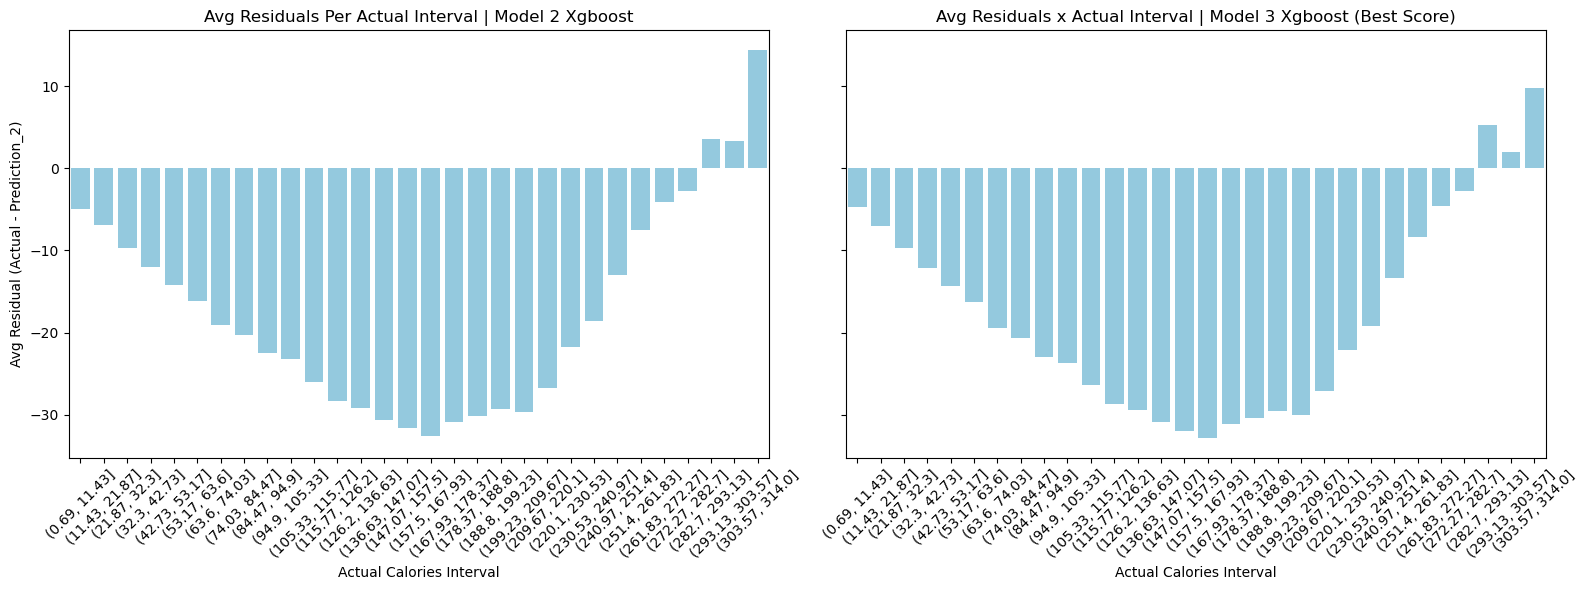

In [108]:
df_results['actual_interval'] = pd.cut(df_results['actual'], bins=30,precision=2)


mean_interval = df_results.groupby('actual_interval', observed=True)[['residual_2', 'residual_3']].mean().reset_index()


fig, ax = plt.subplots(1,2, figsize=(16, 6), sharey=True)

sns.barplot(data=mean_interval, x='actual_interval', y='residual_2', color='skyblue', ax=ax[0])
ax[0].tick_params(axis='x', rotation=45)
ax[0].set_xlabel('Actual Calories Interval')
ax[0].set_ylabel('Avg Residual (Actual - Prediction_2)')
ax[0].set_title('Avg Residuals Per Actual Interval | Model 2 Xgboost')

sns.barplot(data=mean_interval, x='actual_interval', y='residual_3', color='skyblue', ax=ax[1])
ax[1].tick_params(axis='x', rotation=45)
ax[1].set_xlabel('Actual Calories Interval')
ax[1].set_ylabel('Avg Residual (Actual - Prediction_3)')
ax[1].set_title('Avg Residuals x Actual Interval | Model 3 Xgboost (Best Score)')

plt.tight_layout()
plt.show()

## Features Importance with **shap** Lookup

This Graph above can explain the the better impact of residuals in bigger values, we can se more lower value are less "impact" on model prediction

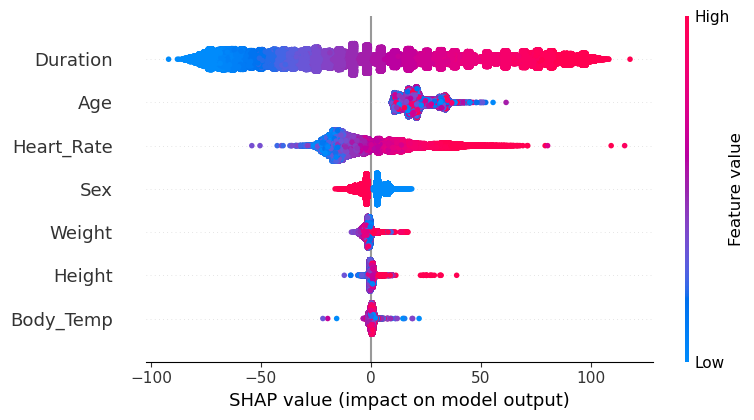

In [109]:
explainer = shap.Explainer(xgb_3)
shap_values = explainer(X_val)
shap.summary_plot(shap_values.values, X_val)

In this plot above we can see the duration is the higher impact to pushing the model to a lower f(x) = calories

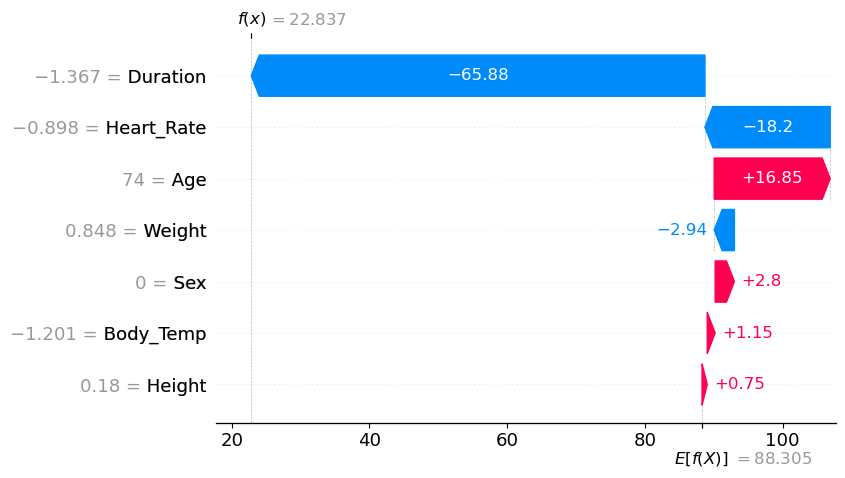

In [114]:
explainer = shap.Explainer(xgb_3)
shap_values = explainer(X_val)
shap.plots.waterfall(shap_values[1])